In [1]:
# 定数
band_colors = ['blue', 'green', 'red', 'orange', 'yellow', 'gray']
band_names = ['u', 'g', 'r', 'i', 'z', 'Y']
classes = [6, 15, 16, 42, 52, 53, 62, 64, 65, 67, 88, 90, 92, 95]
SN_classes = [42, 52, 62, 67, 90]
band_center = [350, 500, 600, 750, 875, 1000]

In [2]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import logging
import time

from sklearn.metrics import confusion_matrix
import cesium.featurize as featurize
import sncosmo
import astropy
import iminuit
from scipy.optimize import curve_fit
from multiprocessing import Pool, cpu_count

import warnings
warnings.filterwarnings("ignore")

In [5]:
# trainデータのロード
train = pd.read_csv('../input/training_set.csv.zip')
train_meta = pd.read_csv('../input/training_set_metadata.csv')

# データのマージ
train_to_fit = train.merge(train_meta, on='object_id')

In [6]:
# バンドごとの最大光度を入れる(maxを取るときにはdetected==1に限る)
train_to_fit = train_to_fit.merge(
                    right=train_to_fit[train_to_fit.detected==1].groupby(['object_id', 'passband'])['flux'].max().to_frame().rename(columns={'flux': 'max_flux'}),
                    on=['object_id', 'passband'],
                    how='outer')

In [7]:
# バンドごとの最大光度を入れる
train_to_fit = train_to_fit.merge(
                    right=train_to_fit[train_to_fit.flux==train_to_fit.max_flux][['object_id', 'passband','mjd']].rename(columns={'mjd': 'max_mjd'}),
                    on=['object_id', 'passband'],
                    how='outer')

In [8]:
# 最大光度日からの日数を記録
train_to_fit['mjd_from_max'] = train_to_fit['mjd'] - train_to_fit['max_mjd']

In [9]:
# 最大光度でnormalize
train_to_fit['norm_flux'] = train_to_fit['flux'] / train_to_fit['max_flux']
train_to_fit['norm_flux_err'] = train_to_fit['flux_err'] / train_to_fit['max_flux']

In [10]:
# LCパラメータの読み込み
opt_param_df = pd.read_csv('../FROM_MYTEAM/sn_template_params_20181129.csv')

In [11]:
# 超新星LCにフィットする関数(0-2でclippingしておく)
def LC_fit_func(x, t0, a, b, c, Tf, Tr):
    return np.clip(a*(1+b*(x-t0)+c*(x-t0)*(x-t0))*np.exp(-(x-t0)/Tf) / (1+np.exp(-(x-t0)/Tr)), a_min=0, a_max=2)

In [12]:
# fittingのχ二乗を求める関数
def get_chisq(x, obs_flux, obs_flux_err, opt_param):
    template_flux = LC_fit_func(x, *opt_param)
    
    # calculate chi-square
    residual = obs_flux - template_flux
    dof = len(residual) - 2 # 横移動と、縦の伸縮の2パラメータでfitしているので観測個数から2を引く
    chisq = np.square(residual / obs_flux_err).sum()/dof
    return chisq

In [13]:
def LC_single_fit(df_, opt_param, d_range=[-30, 30], d_freq=5, flux_range=[1.0, 4.0], flux_freq=0.1):
    '''
    観測データ（df_）にLCを当てはめる
    
    input
        - df_:1天体の観測データ（singleバンドのfitを想定してるので事前にpassbandを絞っておく）
        - opt_param: 当てはめたいLCテンプレートのパラメータ（ndarray）
        - d_range: 観測されてる最大光度日から前後何日を探索するか
        - d_freq: 最大光度日の探索間隔
        - flux_range: 最大光度の探索範囲（log10なので、例えば2はfluxで10**2=100を意味する）
        - flux_freq: 最大光度の探索間隔
        
    output:
        - chisq_list: 各探索毎のχ二乗を入れたndarray
        - min_chisq: 一番小さいχ二乗値
        - f_opt:  一番当てはまりの良かった最大光度（log10(flux)単位）
        - d_opt: 一番当てはまりの良かった（観測）最大光度日からのday差分
        - search_params: 探索範囲の次元(d 方向の探索回数、f方向の探索回数, d_range[0], d_freq, flux_range[0], flux_freq)
    '''   
    # define serach range (max_mjd)
    search_max_mjd_series_ = np.arange(d_range[0], d_range[1]+d_freq, d_freq)
    # define serach range (max_flux)
    search_flux_series_ = np.arange(flux_range[0], flux_range[1]+flux_freq, flux_freq)
    
    # template fit（d, fの探索範囲ごとにχ二乗を計算して格納）
    chisq_list = []
    for d_ in search_max_mjd_series_:
        x = df_.mjd_from_max.values - d_
        for f_ in search_flux_series_:
            f_corr_factor = 10.0**f_
            y = df_.flux.values / f_corr_factor
            yerr = df_.flux_err.values / f_corr_factor
            chisq_ = get_chisq(x, y, yerr, opt_param)
            chisq_list.append(chisq_)
            
    chisq_list = np.array(chisq_list)
    min_chisq = np.min(chisq_list) # 最小のχ二乗
    
    min_index = np.argmin(chisq_list)  #最小のχ二乗のindex
    d_opt = d_range[0] + d_freq * (min_index // len(search_flux_series_)) # χ二乗を最小にするd
    f_opt = flux_range[0] + flux_freq *(min_index % len(search_flux_series_)) # χ二乗を最小にするf（※log10単位）
    search_params = (len(search_max_mjd_series_), len(search_flux_series_), d_range[0], d_freq, flux_range[0], flux_freq)
    
    return chisq_list, min_chisq, d_opt, f_opt, search_params


In [14]:
# フィッティング結果のプロットする関数
def plot_fitting_result(df_, lc_template_param, chisq_list, min_chisq, d_opt, f_opt, search_params):
    fig = plt.figure(figsize=(16,5))
    # 観測点とフィッティングLCのプロット
    ax = fig.add_subplot(1,2,1)
    ax.errorbar(x=df_.mjd_from_max, y=df_.flux, 
             yerr=df_.flux_err, 
             linestyle='None', 
             marker='o',
             label=None
            )
    x_tmp = np.arange(-400, 400, 5)
    ax.plot(x_tmp, LC_fit_func(x_tmp-d_opt, *lc_template_param)* 10.0**f_opt, color='r', 
         label='d_opt={}\nf_opt={}\n$\chi^2 = ${:.5f}'.format(d_opt, f_opt, min_chisq))
    plt.legend(frameon=False)
    plt.xlabel('day from max')
    plt.ylabel('obs.flux')

    # 探索空間で当てはまりの良さをヒートマップでプロット
    ax = fig.add_subplot(1,2,2)
    color_map = ax.imshow(np.exp(-chisq_list/2).reshape(search_params[0],search_params[1]))
    plt.xticks(range(search_params[1]), np.round(search_params[4]+np.arange(search_params[1])*search_params[5],1), rotation=45)
    plt.yticks(range(search_params[0]), search_params[2]+np.arange(search_params[1])*search_params[3])
    plt.xlabel('flux index range')
    plt.ylabel('day range')

    plt.tight_layout()
    plt.show()

In [15]:
# class90のY-bandテンプレートを試しに使ってみる
param = opt_param_df[(opt_param_df.target==90) & (opt_param_df.passband==5) & (opt_param_df.zrange==0)][['t0', 'a', 'b', 'c', 'Tf', 'Tr']].values[0]
param

array([-1.0000000e+01,  1.7940290e+00, -1.4488000e-02,  5.7100000e-03,
        1.1471815e+01,  5.0000000e+00])

In [17]:
train_to_fit[train_to_fit.target==42].object_id.unique()

array([      730,      1632,      2103, ..., 130319749, 130552230,
       130659834])

In [18]:
df = train_to_fit[(train_to_fit.object_id==730) & (train_to_fit.passband==4)]

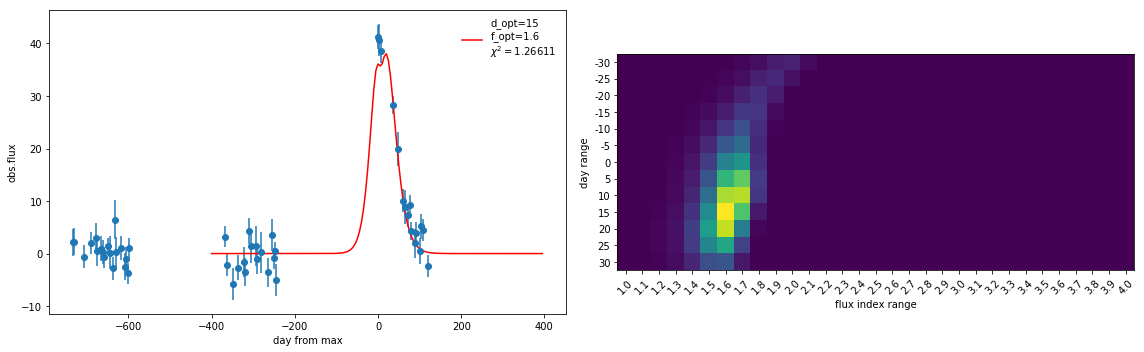

In [19]:
chisq_list, min_chisq, d_opt, f_opt, search_params = LC_single_fit(df, param)
plot_fitting_result(df, param, chisq_list, min_chisq, d_opt, f_opt, search_params)

In [28]:
chisq_list.shape

(403,)

In [29]:
search_params

(13, 31, -30, 5, 1.0, 0.1)

In [30]:
X = np.arange(-400, 400, 5)

In [36]:
def get_feature(oid, target, passband, zrange):
    """
    input:
        oid = 713
        target = 90
        passband = 4
        zrange = 0
    
    output:
        y: array
        min(chisq_list): array
        d_opt: float
        f_opt: float
        search_params: tuple(6 dimensions)
        
    """
    
    param = opt_param_df[(opt_param_df.target==target) & (opt_param_df.passband==passband) & (opt_param_df.zrange==zrange)][['t0', 'a', 'b', 'c', 'Tf', 'Tr']].values[0]
    
    df = train_to_fit[(train_to_fit.object_id==oid) & (train_to_fit.passband==passband)]
    
    chisq_list, min_chisq, d_opt, f_opt, search_params = LC_single_fit(df, param)
    y = LC_fit_func(X-d_opt, *param)* 10.0**f_opt
    
    return y, min(chisq_list), d_opt, f_opt, search_params


In [39]:
y, chisq_list, d_opt, f_opt, search_params = get_feature(745, 90, 4, 1)

In [45]:
y

array([4.97084182e-17, 8.92232830e-17, 1.60102534e-16, 2.87201560e-16,
       5.15039670e-16, 9.23328956e-16, 1.65474309e-15, 2.96455397e-15,
       5.30932109e-15, 9.50529250e-15, 1.70111905e-14, 3.04328309e-14,
       5.44231821e-14, 9.72869904e-14, 1.73840111e-13, 3.10502076e-13,
       5.54361440e-13, 9.89304443e-13, 1.76469455e-12, 3.14634040e-12,
       5.60701986e-12, 9.98716117e-12, 1.77798720e-11, 3.16362134e-11,
       5.62602920e-11, 9.99937887e-11, 1.77618886e-10, 3.15312667e-10,
       5.59397407e-10, 9.91782250e-10, 1.75718954e-09, 3.11111629e-09,
       5.50424252e-09, 9.73083713e-09, 1.71894145e-08, 3.03400516e-08,
       5.35058359e-08, 9.42757344e-08, 1.65957139e-07, 2.91857872e-07,
       5.12751988e-07, 8.99877662e-07, 1.57753151e-06, 2.76228049e-06,
       4.83089570e-06, 8.43783047e-06, 1.47179794e-05, 2.56358988e-05,
       4.45859496e-05, 7.74212034e-05, 1.34212939e-04, 2.32251244e-04,
       4.01147012e-04, 6.91479227e-04, 1.18940012e-03, 2.04120963e-03,
      

In [24]:
opt_param_df[opt_param_df.passband==4]

,passband,t0,a,b,c,Tf,Tr,target,zrange
4,4,5.000000,1.804796,-0.017268,0.001101,23.742034,10.000000,42,0
10,4,5.000000,1.841081,-0.020389,0.000308,22.967277,9.871748,52,0
16,4,-3.016575,1.889663,-0.010000,0.000447,19.769373,8.963278,62,0
22,4,5.000000,1.710404,-0.040728,0.001196,19.992550,8.124957,67,0
28,4,-8.351819,1.288950,-0.011173,0.000040,75.615308,3.594951,90,0
34,4,5.000000,1.809715,-0.011891,0.000403,33.256998,13.791126,42,1
40,4,2.231258,1.891212,-0.040396,0.001591,18.344753,6.078505,52,1
46,4,4.540664,1.853280,-0.023099,0.001007,19.777064,7.866506,62,1
52,4,2.833601,1.878667,-0.040137,0.002629,11.092411,4.501874,67,1
58,4,3.913381,1.853610,-0.044667,0.003356,12.792342,5.000000,90,1


In [22]:
test = pd.read_pickle('../data/test.pkl')

In [23]:
test

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv
0,13,34.453125,-5.229529,169.987075,-59.956185,1,0.3048,0.3193,0.0542,41.1123,0.019
1,14,33.398438,-4.331149,167.226341,-59.936551,1,NaN,0.6323,0.0179,42.8774,0.018
2,17,348.529419,-61.755440,321.293980,-51.763351,1,NaN,0.8297,0.0605,43.6000,0.016
3,23,34.804688,-5.829153,171.307861,-60.174401,1,NaN,0.6533,0.1479,42.9640,0.023
4,34,351.321442,-64.198746,317.458993,-50.429931,1,0.4557,0.4617,0.0122,42.0540,0.023
5,35,35.332031,-5.979157,172.286722,-59.931743,1,NaN,0.8388,0.0375,43.6290,0.022
6,43,0.574468,-45.981140,327.041068,-68.778764,1,NaN,0.6669,0.0546,43.0186,0.006
7,50,0.574468,-45.981140,327.041068,-68.778764,1,NaN,1.4663,0.0529,45.1281,0.006
8,60,346.562500,-63.448284,320.824720,-49.866957,1,NaN,0.9462,0.0116,43.9519,0.021
9,69,349.160583,-64.760857,318.219706,-49.458924,1,NaN,1.0432,0.1092,44.2138,0.020


In [26]:
train_meta

,object_id,ra,decl,gal_l,gal_b,ddf,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
0,615,349.046051,-61.943836,320.796530,-51.753706,1,0.0000,0.0000,0.0000,NaN,0.017,92
1,713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
2,730,33.574219,-6.579593,170.455585,-61.548219,1,0.2320,0.2262,0.0157,40.2561,0.021,42
3,745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
4,1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
5,1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0000,0.0000,0.0000,NaN,0.020,65
6,1598,347.846710,-64.760857,318.929827,-49.143596,1,0.1352,0.1820,0.0304,39.7279,0.019,90
7,1632,348.595886,-63.072620,320.023289,-50.713060,1,0.6857,0.7014,0.0100,43.1524,0.021,42
8,1920,149.414062,3.433834,234.919132,42.245550,1,0.3088,0.3229,0.3360,41.1401,0.027,90
9,1926,149.414062,1.940072,236.565366,41.393323,1,0.0000,0.0000,0.0000,NaN,0.018,65
